ECG Skewness Analyzing Segment Lengths

All Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import scipy.stats as stats
from scipy.stats import skew
import statsmodels.api as sm
import sklearn.linear_model as lm
import warnings
warnings.filterwarnings('ignore')
import neurokit2 as nk


In [35]:
# Fix the file path - make sure this points to your actual data directory
folder_path = Path("/Users/talitheac/Desktop/07 Corrected DS Final IBIs")

# Add debugging to verify the folder exists
if not folder_path.exists():
    raise FileNotFoundError(f"Folder not found: {folder_path}")

# Process all files in the directory
all_data = []

# Loop through all files in the directory with error handling
for file_path in folder_path.glob('*'):
    try:
        df = load_data(file_path)
        if df is not None:  # Only append if data was successfully loaded
            all_data.append(df)
            print(f"Successfully processed: {file_path.name}")
    except Exception as e:
        print(f"Error processing {file_path.name}: {str(e)}")

# Create result_df only if we have data
if all_data:
    result_df = pd.concat(all_data, ignore_index=True)
    print(f"\nTotal rows in result_df: {len(result_df)}")
else:
    raise ValueError("No data was loaded! Check your folder path and file contents.")

Error reading file /Users/talitheac/Desktop/07 Corrected DS Final IBIs/1119_4m_infant_ET: [Errno 21] Is a directory: '/Users/talitheac/Desktop/07 Corrected DS Final IBIs/1119_4m_infant_ET'
Error reading file /Users/talitheac/Desktop/07 Corrected DS Final IBIs/1042_15m_infant_ALL: [Errno 21] Is a directory: '/Users/talitheac/Desktop/07 Corrected DS Final IBIs/1042_15m_infant_ALL'
Error reading file /Users/talitheac/Desktop/07 Corrected DS Final IBIs/1109_18m_infant_ALL: [Errno 21] Is a directory: '/Users/talitheac/Desktop/07 Corrected DS Final IBIs/1109_18m_infant_ALL'
Error reading file /Users/talitheac/Desktop/07 Corrected DS Final IBIs/1002_36m2_infant_ALL: [Errno 21] Is a directory: '/Users/talitheac/Desktop/07 Corrected DS Final IBIs/1002_36m2_infant_ALL'
Error reading file /Users/talitheac/Desktop/07 Corrected DS Final IBIs/1073_24m2_infant_OIX: [Errno 21] Is a directory: '/Users/talitheac/Desktop/07 Corrected DS Final IBIs/1073_24m2_infant_OIX'
Error reading file /Users/talitheac

ValueError: No data was loaded! Check your folder path and file contents.

In [36]:
# Fix the file path
folder_path = Path("/Users/talitheac/Desktop/07 Corrected DS Final IBIs")

# Add debugging to verify folder exists and show contents
if not folder_path.exists():
    raise FileNotFoundError(f"Folder not found: {folder_path}")

# List all files in directory
files = list(folder_path.glob('*'))
print(f"Found {len(files)} files in directory")
for f in files:
    print(f"  - {f.name}")

Found 1800 files in directory
  - 1119_4m_infant_ET
  - 1042_15m_infant_ALL
  - 1109_18m_infant_ALL
  - 1002_36m2_infant_ALL
  - 1073_24m2_infant_OIX
  - 1001_6m_infant_ET
  - 1024_2m_infant_DEV
  - 1084_18m_infant_ALL
  - 1002_15m_infant_ET
  - 1021_3m_infant_OIX
  - 1108_9m_infant_DEV1
  - 1141_15m_infant_ALL
  - 1056_24m1_infant_ALL
  - 1015_15m_infant_ET
  - 1146_4m_infant_ALL
  - 1075_9m_infant_OIX
  - 1026_4m_infant_PIX-OIX
  - 1015_9m_infant_ET1
  - 1071_4mAdj_infant_ALL
  - 1005_18m_infant_OPIX
  - 1076_12m_infant_ALL
  - 1044_9m_infant_DEV2
  - 1107_2m_infant_PIX
  - 1037_9m_infant_ALL
  - 1033_15m_infant_ALL
  - 1026_15m_infant_ALL
  - 2017_6m_infant_PIX
  - 1005_15m_infant_OIX
  - 1021_1w_infant_DEV
  - 1073_1m_infant_PIX
  - 1063_3m_infant_ALL
  - 1059_6m_infant_ALL
  - 1119_4m_infant_PIX
  - 1085_4m_infant_ALL
  - 1088_6m_infant_OIX
  - 1111_12m_infant_ALL
  - 1104_12m_infant_ALL
  - 1028_6m_infant_PIX
  - 1052_18m_infant_DEV2
  - 1012_3m_infant_PIX
  - 1010_12m_infant_DEV

In [3]:
def load_data(file_path):
    print(f"Attempting to load: {file_path}")
    
    # Skip if path is a directory or not a clean IBI file
    if Path(file_path).is_dir() or not file_path.name.endswith('_clean_IBI.txt'):
        print(f"Skipping {file_path.name} - not a clean IBI file")
        return None
        
    try:
        # Try reading as text file with tab separator
        df = pd.read_csv(file_path, 
                       sep='\t',
                       header=None,
                       usecols=[0, 1, 3],
                       names=['timestamp', 'beats', 'ibi'])
        print(f"Successfully loaded {len(df)} rows from {file_path.name}")
    except Exception as e:
        print(f"Failed to load {file_path.name}: {str(e)}")
        return None
    
    # Extract file information
    file_name = Path(file_path).name
    parts = file_name.split('_')
    
    # Add error checking for filename parts
    if len(parts) >= 4:
        df['ID'] = parts[0]
        df['Age'] = parts[1]
        df['exp'] = parts[3]
    else:
        print(f"Warning: Filename {file_name} doesn't match expected format")
        df['ID'] = file_name
        df['Age'] = 'unknown'
        df['exp'] = 'unknown'
    
    # Filter IBI values
    df = df[df.ibi < 2000]
    
    return df

# Process all files in the directory
folder_path = Path("/Users/talitheac/Desktop/07 Corrected DS Final IBIs")
all_data = []

# Use recursive glob to find only clean IBI files
for file_path in folder_path.rglob('*_clean_IBI.txt'):
    try:
        df = load_data(file_path)
        if df is not None:  # Only append if data was successfully loaded
            all_data.append(df)
            print(f"Successfully processed: {file_path.name}")
    except Exception as e:
        print(f"Error processing {file_path.name}: {str(e)}")

# Create result_df only if we have data
if all_data:
    result_df = pd.concat(all_data, ignore_index=True)
    print(f"\nTotal rows in result_df: {len(result_df)}")
    print(f"Number of unique subjects: {result_df['ID'].nunique()}")
else:
    print("No data was loaded! Check your folder path and file contents.")

NameError: name 'Path' is not defined

In [45]:
# Try loading a single file first
files = list(folder_path.glob('*'))
if files:
    result_df = load_data(files[0])
    print("\nFirst few rows of loaded data:")
    print(result_df.head())
else:
    print("No files found in directory")

Attempting to load: /Users/talitheac/Desktop/07 Corrected DS Final IBIs/1119_4m_infant_ET
Skipping directory: /Users/talitheac/Desktop/07 Corrected DS Final IBIs/1119_4m_infant_ET

First few rows of loaded data:


AttributeError: 'NoneType' object has no attribute 'head'

In [40]:

#2. Load a single file first to test:
file_path = Path("/Users/talitheac/asd_ecgskew/asd_project/data/processed/07 Corrected DS Final IBIs")
result_df = load_data(file_path)
if result_df is not None:
    print("Successfully loaded data")
    print(f"Shape: {result_df.shape}")


Attempting to load: /Users/talitheac/asd_ecgskew/asd_project/data/processed/07 Corrected DS Final IBIs
Excel read failed: [Errno 21] Is a directory: '/Users/talitheac/asd_ecgskew/asd_project/data/processed/07 Corrected DS Final IBIs'
CSV read failed: [Errno 21] Is a directory: '/Users/talitheac/asd_ecgskew/asd_project/data/processed/07 Corrected DS Final IBIs'


IsADirectoryError: [Errno 21] Is a directory: '/Users/talitheac/asd_ecgskew/asd_project/data/processed/07 Corrected DS Final IBIs'

In [38]:
# First, make sure your folder path is correct and exists
folder_path = Path("/Users/talitheac/Desktop/07 Corrected DS Final IBIs")

# Add some error checking
if not folder_path.exists():
    raise FileNotFoundError(f"Folder not found: {folder_path}")

# Add some debugging to see what files are found
files = list(folder_path.glob('*'))
print(f"Found {len(files)} files in directory")
for f in files:
    print(f"  - {f.name}")

# Process all files in the directory
all_data = []

# Loop through all files in the directory
for file_path in folder_path.glob('*'):
    try:
        df = load_data(file_path)
        all_data.append(df)
        print(f"Successfully processed: {file_path.name}")
    except Exception as e:
        print(f"Error processing {file_path.name}: {str(e)}")

# Check if we have any data before creating result_df
if all_data:
    result_df = pd.concat(all_data, ignore_index=True)
    print(f"\nTotal rows in result_df: {len(result_df)}")
else:
    raise ValueError("No data was loaded! Check your folder path and file contents.")

Found 1800 files in directory
  - 1119_4m_infant_ET
  - 1042_15m_infant_ALL
  - 1109_18m_infant_ALL
  - 1002_36m2_infant_ALL
  - 1073_24m2_infant_OIX
  - 1001_6m_infant_ET
  - 1024_2m_infant_DEV
  - 1084_18m_infant_ALL
  - 1002_15m_infant_ET
  - 1021_3m_infant_OIX
  - 1108_9m_infant_DEV1
  - 1141_15m_infant_ALL
  - 1056_24m1_infant_ALL
  - 1015_15m_infant_ET
  - 1146_4m_infant_ALL
  - 1075_9m_infant_OIX
  - 1026_4m_infant_PIX-OIX
  - 1015_9m_infant_ET1
  - 1071_4mAdj_infant_ALL
  - 1005_18m_infant_OPIX
  - 1076_12m_infant_ALL
  - 1044_9m_infant_DEV2
  - 1107_2m_infant_PIX
  - 1037_9m_infant_ALL
  - 1033_15m_infant_ALL
  - 1026_15m_infant_ALL
  - 2017_6m_infant_PIX
  - 1005_15m_infant_OIX
  - 1021_1w_infant_DEV
  - 1073_1m_infant_PIX
  - 1063_3m_infant_ALL
  - 1059_6m_infant_ALL
  - 1119_4m_infant_PIX
  - 1085_4m_infant_ALL
  - 1088_6m_infant_OIX
  - 1111_12m_infant_ALL
  - 1104_12m_infant_ALL
  - 1028_6m_infant_PIX
  - 1052_18m_infant_DEV2
  - 1012_3m_infant_PIX
  - 1010_12m_infant_DEV

ValueError: All objects passed were None

In [8]:
 #First, make sure your folder path is correct
folder_path = Path("/Users/talitheac/Desktop/07 Corrected DS Final IBIs")

# Add some error checking and debugging
all_data = []

# Loop through all files in the directory
for file_path in folder_path.glob('*'):
    try:
        df = load_data(file_path)
        all_data.append(df)
        print(f"Successfully processed: {file_path.name}")
    except Exception as e:
        print(f"Error processing {file_path.name}: {str(e)}")

# Check if we have any data before creating result_df
if all_data:
    result_df = pd.concat(all_data, ignore_index=True)
    print(f"\nTotal rows in result_df: {len(result_df)}")
else:
    print("\nNo data was loaded! Check your folder path and file contents.")

Error processing 1119_4m_infant_ET: [Errno 21] Is a directory: '/Users/talitheac/Desktop/07 Corrected DS Final IBIs/1119_4m_infant_ET'
Error processing 1042_15m_infant_ALL: [Errno 21] Is a directory: '/Users/talitheac/Desktop/07 Corrected DS Final IBIs/1042_15m_infant_ALL'
Error processing 1109_18m_infant_ALL: [Errno 21] Is a directory: '/Users/talitheac/Desktop/07 Corrected DS Final IBIs/1109_18m_infant_ALL'
Error processing 1002_36m2_infant_ALL: [Errno 21] Is a directory: '/Users/talitheac/Desktop/07 Corrected DS Final IBIs/1002_36m2_infant_ALL'
Error processing 1073_24m2_infant_OIX: [Errno 21] Is a directory: '/Users/talitheac/Desktop/07 Corrected DS Final IBIs/1073_24m2_infant_OIX'
Error processing 1001_6m_infant_ET: [Errno 21] Is a directory: '/Users/talitheac/Desktop/07 Corrected DS Final IBIs/1001_6m_infant_ET'
Error processing 1024_2m_infant_DEV: [Errno 21] Is a directory: '/Users/talitheac/Desktop/07 Corrected DS Final IBIs/1024_2m_infant_DEV'
Error processing 1084_18m_infant_

Define file path

In [9]:


def load_data(file_path):
    # Read the data file - supports both Excel and text files
    try:
        # First try reading as Excel
        df = pd.read_excel(file_path, 
                          usecols=[0, 1, 3],
                          names=['timestamp', 'beats', 'ibi'])
    except:
        # If Excel fails, try reading as text file
        df = pd.read_csv(file_path, 
                        sep='\t',
                        header=None,
                        usecols=[0, 1, 3],
                        names=['timestamp', 'beats', 'ibi'])
    
    # Extract file information
    file_name = Path(file_path).name
    parts = file_name.split('_')
    df['ID'] = parts[0]
    df['Age'] = parts[1]
    df['exp'] = parts[3]
    
    # Filter IBI values
    df = df[df.ibi < 2000]
    
    return df

# Process all files in the directory
folder_path = Path("/Users/talitheac/Desktop/07 Corrected DS Final IBIs")
all_data = []

# Loop through all files in the directory
for file_path in folder_path.glob('*'):  # This will get all files
    try:
        df = load_data(file_path)
        all_data.append(df)
        print(f"Successfully processed: {file_path.name}")
    except Exception as e:
        print(f"Error processing {file_path.name}: {str(e)}")

# Combine all dataframes
if all_data:
    result_df = pd.concat(all_data, ignore_index=True)

Error processing 1119_4m_infant_ET: [Errno 21] Is a directory: '/Users/talitheac/Desktop/07 Corrected DS Final IBIs/1119_4m_infant_ET'
Error processing 1042_15m_infant_ALL: [Errno 21] Is a directory: '/Users/talitheac/Desktop/07 Corrected DS Final IBIs/1042_15m_infant_ALL'
Error processing 1109_18m_infant_ALL: [Errno 21] Is a directory: '/Users/talitheac/Desktop/07 Corrected DS Final IBIs/1109_18m_infant_ALL'
Error processing 1002_36m2_infant_ALL: [Errno 21] Is a directory: '/Users/talitheac/Desktop/07 Corrected DS Final IBIs/1002_36m2_infant_ALL'
Error processing 1073_24m2_infant_OIX: [Errno 21] Is a directory: '/Users/talitheac/Desktop/07 Corrected DS Final IBIs/1073_24m2_infant_OIX'
Error processing 1001_6m_infant_ET: [Errno 21] Is a directory: '/Users/talitheac/Desktop/07 Corrected DS Final IBIs/1001_6m_infant_ET'
Error processing 1024_2m_infant_DEV: [Errno 21] Is a directory: '/Users/talitheac/Desktop/07 Corrected DS Final IBIs/1024_2m_infant_DEV'
Error processing 1084_18m_infant_

In [10]:
#segment length function

def seg_len(result_df, time_col, segment_seconds):
    # Ensure the time column is in datetime format, with seconds precision
    result_df[time_col] = pd.to_datetime(result_df[time_col], unit='s')
    result_df = result_df.set_index(time_col)
    
    segments = [group for _, group in result_df.resample(f'{segment_seconds}S')]
    
    return segments

# Split data into 1-minute (60-second) segments
segments_1min = seg_len(result_df, 'timestamp', 60)

# Split data into 10-minute (600-second) segments
segments_10min = seg_len(result_df, 'timestamp', 600)
segments_1min = seg_len(result_df, 'timestamp', 60)
print(f"Number of 1-minute segments: {len(segments_1min)}")
print(f"\nFirst segment data:\n{segments_1min[0]}")

#  Print summary statistics for each segment
for i, segment in enumerate(segments_1min[:3]):  # Print first 3 segments
    print(f"\nSegment {i+1} summary:")
    print(f"Number of data points: {len(segment)}")
    print(f"Mean IBI: {segment['ibi'].mean():.2f}")
    print(f"Skewness: {segment['ibi'].skew():.2f}")

#  Compare different segment lengths
segments_10min = seg_len(result_df, 'timestamp', 600)
print(f"\nNumber of 10-minute segments: {len(segments_10min)}")
print(f"Number of 1-minute segments: {len(segments_1min)}")

# Compare
segments_5min = seg_len(result_df, 'timestamp', 300)
print(f"\nNumber of 5-minute segments: {len(segments_5min)}")
print(f"Number of 10-minute segments: {len(segments_10min)}")

NameError: name 'result_df' is not defined

In [ ]:
def bootstrap_skewness(result_df, seg_len, n_iterations=1000):
    skews = []
    for _ in tqdm(list(range(n_iterations)), leave=False):
        #this is sampling the ibi values with replacement, so not changing the original data
        ibi = result_df['ibi'].sample(n=len(result_df), replace=True).reset_index(drop=True)
        # converting the ibi values to minutes
        time = np.cumsum(ibi)
        #this is creating a new dataframe with the ibi values and the time values
        temp_df = pd.DataFrame({'ibi': ibi, 'segment_no': (time / 1000 / 60 / seg_len).astype(int)})
        #this is calculating the skewness of the ibi values for each time segment
        group_skews = temp_df.groupby('segment_no')['ibi'].apply(skew)
        #this is appending the mean of the skewness values to the skews list
        skews.append(np.mean(group_skews))
    return skews
seg_lengths = seg_len(result_df,'timestamp', 300)
#example with 5 mins
seg_length = 5
skew_res = bootstrap_skewness(result_df, seg_length, 1000)
print("Bootstrap Skewness for 5 minutes:", skew_res)


Bootstrap Skewness for 5 minutes: [-0.5954678449867725, -0.5780103177595207, -0.561951995124935, -0.5686461909851327, -0.5799056880574021, -0.6284404077180178, -0.5927963983415536, -0.569811091881451, -0.6392505993049697, -0.5892016071914561, -0.5749133335165446, -0.6425574706968374, -0.5837126047817055, -0.594960877517922, -0.575781620328997, -0.6461476145546048, -0.6362859317634492, -0.5754431244319811, -0.6098968947441171, -0.5970160732138758, -0.6006613159249679, -0.6018127607133679, -0.6046346600864179, -0.6456787734947407, -0.5817930559624195, -0.6034502934357127, -0.5806100782099846, -0.6027937616269594, -0.5739829828787809, -0.6315347031341064, -0.5671216542170149, -0.6340746402101095, -0.5264786053925984, -0.6134856612328359, -0.5923957111911871, -0.5972630721404155, -0.5723996565770256, -0.6138291317934439, -0.6256291772733265, -0.6334022742698858, -0.6320954676164847, -0.6026172912502102, -0.6379362104137076, -0.5957111937940559, -0.5987370968176541, -0.5635520960234051, -0.

In [ ]:
#Bootstrap for 1 min
seg_lengths = seg_len(result_df, 'timestamp', 60)
seg_length = 1
skew_res = bootstrap_skewness(result_df, seg_length, 1000)
print("Bootstrap Skewness for 1 minutes:", skew_res)

Bootstrap Skewness for 1 minutes: [-0.6036895577256258, -0.581628542901325, -0.5149205766648947, -0.5572083757086517, -0.5672253387695881, -0.5542826729585018, -0.6029002766930588, -0.576139693155348, -0.5540571317955156, -0.5824061312004546, -0.5669379991012868, -0.5725471159123039, -0.5427480932784968, -0.5599964828412697, -0.6422942297785499, -0.5508296298616248, -0.5903962505903244, -0.5153780279721909, -0.5659556922066241, -0.5703205243809019, -0.586655000902422, -0.5325834213574886, -0.5111760742808568, -0.5600029359605391, -0.6077929026108316, -0.5199544697762878, -0.6314894480088287, -0.6088613981857922, -0.5204095058059179, -0.5162980274018685, -0.6053543325873297, -0.5936509211076022, -0.5248882106166822, -0.5834597808205005, -0.5687417166180782, -0.5578325655952382, -0.5457277673779454, -0.5663397253630801, -0.5933417536486802, -0.5442830985930202, -0.5799973774866638, -0.5467670294721222, -0.5793052725596195, -0.591687323952099, -0.583424873783917, -0.5573334759860861, -0.5

In [ ]:
#Bootstrap 2 min
seg_lengths = seg_len(result_df, 'timestamp', 120)
seg_length = 2
skew_res = bootstrap_skewness(result_df, seg_length, 1000)
print("Bootstrap Skewness for 2 minutes:", skew_res)

Bootstrap Skewness for 2 minutes: [-0.6228689718678667, -0.6121297739110314, -0.6065567435411862, -0.547434716912887, -0.6158249682841198, -0.5780474307362473, -0.5915557727891645, -0.6571899131536891, -0.6211587655153442, -0.600524382627189, -0.5858468513762207, -0.5725844942638175, -0.5895257914805837, -0.5712966558799034, -0.5895855370766716, -0.5792545307644701, -0.5930518886778786, -0.6289112184650621, -0.6663598700626396, -0.5582951545015616, -0.6119220309546404, -0.5488342091490768, -0.5583057718251705, -0.5675110314532883, -0.6540475725780375, -0.5640013616033319, -0.5762622554334944, -0.5931303367973577, -0.6049025124673681, -0.5724882386850878, -0.5366005889305855, -0.5918422449429986, -0.6040096610237726, -0.5693493712150972, -0.5404078344516474, -0.5836896846497072, -0.6117876857588274, -0.6000227020837821, -0.5622211205127557, -0.525213685378346, -0.6203025446783782, -0.5946656240614301, -0.6301151880635304, -0.5822830207790859, -0.5657539278252703, -0.5451517788367792, -0

In [ ]:
#Bootstrap for 3 min
seg_lengths = seg_len(result_df, 'timestamp', 180)
seg_length = 3
skew_res = bootstrap_skewness(result_df, seg_length, 1000)
print("Bootstrap Skewness for 3 minutes:", skew_res)

Bootstrap Skewness for 3 minutes: [-0.5553858918414795, -0.5855483811231359, -0.5927120818030491, -0.627671813875528, -0.6029148276407584, -0.5704934063175353, -0.5571077393287521, -0.6092168962777585, -0.5665770397882479, -0.5678885282197507, -0.602284940217482, -0.5936213239976416, -0.5676269243702984, -0.6110973554010695, -0.5962039811204056, -0.5547434364699925, -0.6471548272215938, -0.5606044304164681, -0.59328306911947, -0.5986659780609249, -0.58747182981032, -0.6040109969007361, -0.6531277057761817, -0.6121057066626852, -0.618394101925377, -0.578952351687945, -0.5603343306431122, -0.5971947778386442, -0.5580923291203711, -0.5576055973617685, -0.5666277722848997, -0.6085375575852157, -0.6126040033436462, -0.6226268956487807, -0.6485652245486389, -0.5945523322375904, -0.6082751141950594, -0.5979788163936784, -0.5574559482761307, -0.6289403694062818, -0.6499345866736513, -0.5825347740648519, -0.6413927981171313, -0.5747781642904607, -0.6505633684607609, -0.5988091561892669, -0.5810

In [ ]:
#Bootstrap for 4 min
seg_lengths = seg_len(result_df, 'timestamp', 240)
seg_length = 4
skew_res = bootstrap_skewness(result_df, seg_length, 1000)
print("Bootstrap Skewness for 4 minutes:", skew_res)

Bootstrap Skewness for 4 minutes: [-0.6028864416233197, -0.6058472724391638, -0.6270279949890212, -0.6174117343013, -0.6112810056103622, -0.5907697522991554, -0.5802226756154458, -0.5899024816549561, -0.5966725310278909, -0.5888935563856454, -0.5862688882004576, -0.5932306543154885, -0.6260824012989763, -0.6060644940251867, -0.5675836652050756, -0.6314658106107194, -0.6243627484989498, -0.6198521451260369, -0.5998127870877028, -0.5765780304598019, -0.6182907589864983, -0.6416143673691851, -0.5777304737729883, -0.504563743492502, -0.5233306883241368, -0.6489187973867552, -0.5889470133459288, -0.5645314873006424, -0.5881554414094977, -0.6046286748939365, -0.6229862370685644, -0.5703563657699533, -0.6069151020746572, -0.6201914209286132, -0.6033467094608813, -0.587039587983966, -0.6260062873052428, -0.5664538279834278, -0.5770928430128597, -0.5778064508536419, -0.5818820502833536, -0.6013790134513566, -0.6058038770575753, -0.5748431668540134, -0.616665853908881, -0.6316843761010775, -0.59

In [ ]:
#Bootstrap for 5 min
seg_lengths = seg_len(result_df, 'timestamp', 300)
seg_length = 5
skew_res = bootstrap_skewness(result_df, seg_length, 1000)
print("Bootstrap Skewness for 5 minutes:", skew_res)

Bootstrap Skewness for 5 minutes: [-0.5906229836022029, -0.5810164038296713, -0.6249511608088969, -0.6523837960722716, -0.561482553752161, -0.5639596851362251, -0.5686424241547736, -0.5617311486856252, -0.6418514084597138, -0.5959137701500107, -0.6037817319745875, -0.5826785226302974, -0.5518227194100468, -0.5736897631683121, -0.5791473907472723, -0.5887476589197895, -0.5419704525484939, -0.6101230551793264, -0.5804025319930513, -0.5908284126441137, -0.5587736796784323, -0.6024854462604247, -0.5806344767253722, -0.6456129041035636, -0.5792190884232814, -0.6033901333572317, -0.6182831067458402, -0.6025592396359061, -0.5597359510640552, -0.5816945280786553, -0.5616161471261902, -0.636762862293283, -0.6037881692710688, -0.6188479739827892, -0.5752643790518807, -0.577792120251758, -0.5830100252990383, -0.5937909601788123, -0.6618699210376935, -0.6568719713902614, -0.6185190443298308, -0.6426373959563938, -0.5461811202033888, -0.6286410040228855, -0.5959746743851119, -0.5599531612800945, -0

In [ ]:
#Bootstrap for 6 min
seg_lengths = seg_len(result_df, 'timestamp', 360)
seg_length = 6
skew_res = bootstrap_skewness(result_df, seg_length, 1000)
print("Bootstrap Skewness for 6 minutes:", skew_res)

Bootstrap Skewness for 6 minutes: [-0.5845462508315856, -0.6479972461402257, -0.6101109255896862, -0.5717514861341103, -0.6194740800570732, -0.6459351884836231, -0.6512501728621831, -0.5986505134019059, -0.564855577295708, -0.6286926980401821, -0.5869441649197048, -0.5817463827884949, -0.6149413732667431, -0.6142459016581654, -0.6380849450153339, -0.6228230517441705, -0.5648218263919941, -0.596286255566094, -0.6469624351560087, -0.5909056901633088, -0.6154791603734634, -0.5605419389314382, -0.5910797677157377, -0.589369061824635, -0.595088628901162, -0.6131621215211828, -0.553345567859297, -0.6012837334352438, -0.5714739080861525, -0.5586991057206913, -0.5660633094117705, -0.5839728833000863, -0.5359966647029256, -0.6226420106987194, -0.6397453864258633, -0.5711643002013905, -0.632129718299441, -0.6353923510762997, -0.5983655135029771, -0.600356983326395, -0.610340132957387, -0.6648828919439954, -0.591725672641657, -0.5651190907358644, -0.6121014957843028, -0.5580068713792056, -0.58867

In [ ]:
#Bootstrap for 7 min
seg_lengths = seg_len(result_df, 'timestamp', 420)
seg_length = 7
kew_res = bootstrap_skewness(result_df, seg_length, 1000)
print("Bootstrap Skewness for 7 minutes:", skew_res)

Bootstrap Skewness for 7 minutes: [-0.5845462508315856, -0.6479972461402257, -0.6101109255896862, -0.5717514861341103, -0.6194740800570732, -0.6459351884836231, -0.6512501728621831, -0.5986505134019059, -0.564855577295708, -0.6286926980401821, -0.5869441649197048, -0.5817463827884949, -0.6149413732667431, -0.6142459016581654, -0.6380849450153339, -0.6228230517441705, -0.5648218263919941, -0.596286255566094, -0.6469624351560087, -0.5909056901633088, -0.6154791603734634, -0.5605419389314382, -0.5910797677157377, -0.589369061824635, -0.595088628901162, -0.6131621215211828, -0.553345567859297, -0.6012837334352438, -0.5714739080861525, -0.5586991057206913, -0.5660633094117705, -0.5839728833000863, -0.5359966647029256, -0.6226420106987194, -0.6397453864258633, -0.5711643002013905, -0.632129718299441, -0.6353923510762997, -0.5983655135029771, -0.600356983326395, -0.610340132957387, -0.6648828919439954, -0.591725672641657, -0.5651190907358644, -0.6121014957843028, -0.5580068713792056, -0.58867

In [ ]:
#Bootstrap for 8 min
seg_lengths = seg_len(result_df, 'timestamp', 480)
seg_length = 8
kew_res = bootstrap_skewness(result_df, seg_length, 1000)
print("Bootstrap Skewness for 8 minutes:", skew_res)

Bootstrap Skewness for 8 minutes: [-0.5845462508315856, -0.6479972461402257, -0.6101109255896862, -0.5717514861341103, -0.6194740800570732, -0.6459351884836231, -0.6512501728621831, -0.5986505134019059, -0.564855577295708, -0.6286926980401821, -0.5869441649197048, -0.5817463827884949, -0.6149413732667431, -0.6142459016581654, -0.6380849450153339, -0.6228230517441705, -0.5648218263919941, -0.596286255566094, -0.6469624351560087, -0.5909056901633088, -0.6154791603734634, -0.5605419389314382, -0.5910797677157377, -0.589369061824635, -0.595088628901162, -0.6131621215211828, -0.553345567859297, -0.6012837334352438, -0.5714739080861525, -0.5586991057206913, -0.5660633094117705, -0.5839728833000863, -0.5359966647029256, -0.6226420106987194, -0.6397453864258633, -0.5711643002013905, -0.632129718299441, -0.6353923510762997, -0.5983655135029771, -0.600356983326395, -0.610340132957387, -0.6648828919439954, -0.591725672641657, -0.5651190907358644, -0.6121014957843028, -0.5580068713792056, -0.58867

In [ ]:
#Bootstrap for 9 min
seg_lengths = seg_len(result_df, 'timestamp', 540)
seg_length = 9
skew_res = bootstrap_skewness(result_df, seg_length, 1000)
print("Bootstrap Skewness for 9 minutes:", skew_res)

Bootstrap Skewness for 9 minutes: [-0.6109987584805525, -0.6053388407606474, -0.6442821068168073, -0.5645685355309771, -0.6805127028446045, -0.5825973940875693, -0.5737369577295681, -0.5814224394258979, -0.6899334281320735, -0.5855508403609423, -0.6667927679654365, -0.6001759074249361, -0.5771309170186204, -0.6175006333237736, -0.5067724298294738, -0.5608295291886053, -0.6383920913706046, -0.5931230354160084, -0.6168819816234283, -0.6310904780392967, -0.6109636673799727, -0.5775470898231422, -0.5581841244850407, -0.6522824379830985, -0.5936548130851687, -0.5801527744833828, -0.4908191415324753, -0.6045321148381183, -0.5976473915268068, -0.5819883602155576, -0.626693990878373, -0.6817153186802096, -0.6187653738521479, -0.5599133392389295, -0.6045840466443828, -0.6115052436541021, -0.6131353337995559, -0.5834628541891912, -0.6240924981213876, -0.598855449181351, -0.5472072389843904, -0.6148561087855627, -0.6306956900540447, -0.6048341766956271, -0.5853205380790116, -0.5680712021023113, -

In [ ]:
#Bootstrap for 10 min
seg_lengths = seg_len(result_df, 'timestamp', 60)
seg_length = 10
skew_res = bootstrap_skewness(result_df, seg_length, 1000)
print("Bootstrap Skewness for 10 minutes:", skew_res)

Bootstrap Skewness for 10 minutes: [-0.6432412354974931, -0.6123160222295758, -0.5223701323433532, -0.628197042998894, -0.6896056759086987, -0.5790584349592655, -0.5689518141011348, -0.6074151577853308, -0.6087097990139742, -0.5835662713288133, -0.5514597304726991, -0.638841963399265, -0.6293261125172007, -0.5563931721336852, -0.6385558817333218, -0.5562944956134445, -0.5662563661728475, -0.5880403244844902, -0.6359701615564505, -0.6015616231891067, -0.6283091050052414, -0.614491079009578, -0.5337677652076257, -0.5493780071412778, -0.6322133995905952, -0.547463546556954, -0.5959274303627381, -0.543236320812404, -0.6055374901639168, -0.6494403197317307, -0.6038931075292006, -0.5485639591924909, -0.575829841476331, -0.6165987399733438, -0.5762171741792472, -0.625697252599839, -0.6312913297944238, -0.6505210505352579, -0.6269517400360862, -0.5932960784128619, -0.5878743829505577, -0.6136207355153069, -0.6353391337554766, -0.5361076419311648, -0.5964664926558356, -0.5580884451565447, -0.64

Golden Mean Skewness: -0.608
Bootstrap Mean Skewness: -0.603
Difference: 0.006


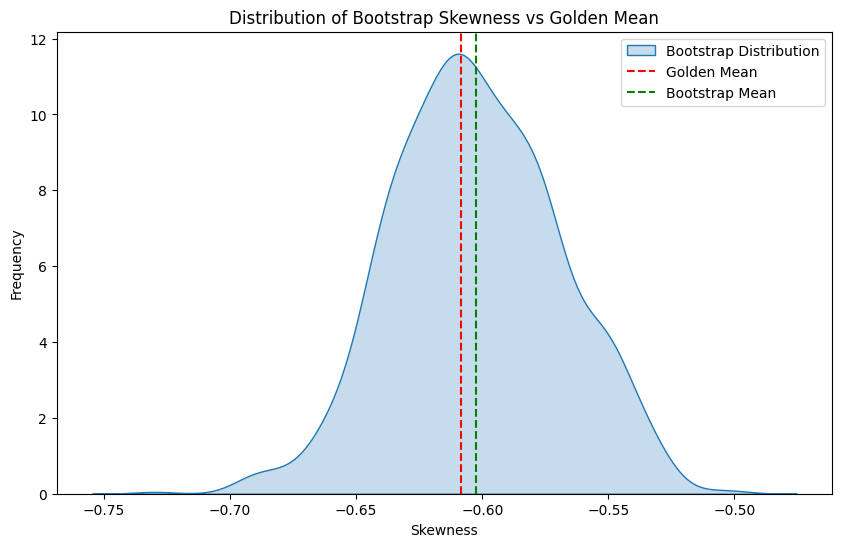

In [ ]:
# Calculate the overall "golden mean" skewness from all recordings
golden_mean_skew = result_df['ibi'].skew()

# Get mean from bootstrap distribution
bootstrap_mean_skew = np.mean(skew_res)

# Compare the values and calculate difference
print(f"Golden Mean Skewness: {golden_mean_skew:.3f}")
#bootstrap mean skewness of i
print(f"Bootstrap Mean Skewness: {bootstrap_mean_skew:.3f}")
print(f"Difference: {abs(golden_mean_skew - bootstrap_mean_skew):.3f}")

# Visualize the comparison
plt.figure(figsize=(10, 6))
sns.kdeplot(data=skew_res, fill=True, label='Bootstrap Distribution')
plt.axvline(golden_mean_skew, color='r', linestyle='--', label='Golden Mean')
plt.axvline(bootstrap_mean_skew, color='g', linestyle='--', label='Bootstrap Mean')
plt.title('Distribution of Bootstrap Skewness vs Golden Mean')
plt.xlabel('Skewness')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
def process_file(file_path, n_iterations=1000):
    df = load_data(file_path)
    results = []
    # Define segment lengths from 1 to 10 minutes (in seconds)
    segment_lengths = range(60, 600, 60)  # 60 seconds to 600 seconds (1 to 10 minutes)
    
    # For each segment length
    for seg_length_seconds in tqdm(segment_lengths, leave=False):
        # Convert seconds to minutes for the results
        seg_length_minutes = seg_length_seconds // 60
        
        # Get skewness values for this segment length
        skewness_values = bootstrap_skewness(df, seg_length_minutes, n_iterations)
        
        n_iter = len(skewness_values)
        results.append(pd.DataFrame({
            'ID': [df['ID'].iloc[0]] * n_iter,
            'Age': [df['Age'].iloc[0]] * n_iter,
            'exp': [df['exp'].iloc[0]] * n_iter,
            'seg_len': [seg_length_minutes] * n_iter,
            'iteration': list(range(n_iter)),
            'skewness': skewness_values
        }))

    return pd.concat(results)

final_df = process_file(file_path, n_iterations=100)
print(final_df)

      ID Age  exp  seg_len  iteration  skewness
0   2003  6m  ALL        1          0 -0.526812
1   2003  6m  ALL        1          1 -0.583956
2   2003  6m  ALL        1          2 -0.548966
3   2003  6m  ALL        1          3 -0.586665
4   2003  6m  ALL        1          4 -0.575401
..   ...  ..  ...      ...        ...       ...
95  2003  6m  ALL        9         95 -0.647488
96  2003  6m  ALL        9         96 -0.575951
97  2003  6m  ALL        9         97 -0.616349
98  2003  6m  ALL        9         98 -0.589223
99  2003  6m  ALL        9         99 -0.547011

[900 rows x 6 columns]


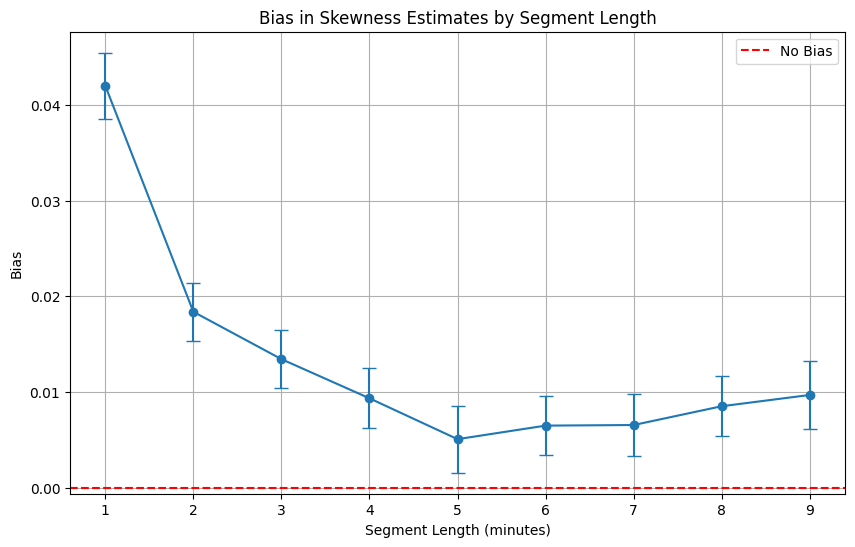


Bias Results:
   segment_length  mean_bias   bias_se
0               1   0.041988  0.003434
1               2   0.018392  0.003045
2               3   0.013450  0.003048
3               4   0.009363  0.003147
4               5   0.005099  0.003502
5               6   0.006513  0.003088
6               7   0.006575  0.003239
7               8   0.008536  0.003148
8               9   0.009712  0.003555


In [ ]:
def calculate_bias_skewness(df):
    # Calculate true skewness for each segment length
    true_skewness = result_df['ibi'].skew()
    
    # Calculate bias for each bootstrap iteration
    bias = df['skewness'] - true_skewness
    
    #calcute the unique segment lengths in dataframe seg_len
    segment_lengths = df['seg_len'].unique()
    
    # Calculate mean bias and SE for each segment length
    bias_results = []
    for seg in segment_lengths:
        seg_bias = bias[df['seg_len'] == seg]
        mean_bias = seg_bias.mean()
        bias_se = seg_bias.std() / np.sqrt(len(seg_bias))
        
        bias_results.append({
            'segment_length': seg,
            'mean_bias': mean_bias,
            'bias_se': bias_se
        })
    
    return pd.DataFrame(bias_results)
bias_results = calculate_bias_skewness(final_df)

plt.figure(figsize=(10, 6))
plt.errorbar(bias_results['segment_length'], 
            bias_results['mean_bias'],
            yerr=bias_results['bias_se'],
            fmt='o-',
            capsize=5)
plt.axhline(y=0, color='r', linestyle='--', label='No Bias')
plt.xlabel('Segment Length (minutes)')
plt.ylabel('Bias')
plt.title('Bias in Skewness Estimates by Segment Length')
plt.legend()
plt.grid(True)
plt.show()

# Print results
print("\nBias Results:")
print(bias_results)

In [ ]:

recompute = True

for path in tqdm(list(Path("/Users/talitheac/data_bradshaw/datacsv.csv/").glob("*.txt"))):
    fname_out = path.name + "result.csv"
    if not Path(fname_out).exists() or recompute:
        final_df = process_file(file_path, n_iterations=10)
        final_df.to_csv(fname_out)
        

  0%|          | 0/6 [00:00<?, ?it/s]




























 17%|█▋        | 1/6 [00:01<00:08,  1.76s/it]





























 33%|███▎      | 2/6 [00:03<00:07,  1.94s/it]




























 50%|█████     | 3/6 [00:05<00:05,  1.92s/it]






























 67%|██████▋   | 4/6 [00:07<00:03,  1.94s/it]





























 83%|████████▎ | 5/6 [00:09<00:01,  1.93s/it]





























100%|██████████| 6/6 [00:11<00:00,  1.93s/it]


In [ ]:
# Pwill change when I have more files
file_paths = [
    "/Users/talitheac/data_bradshaw/datacsv.csv/2003_6m_infant_ALL_clean_IBI.txt"
]
def process_multiple_files(file_paths):
    all_results = []
    #this is looping through the file paths and processing each file
    for gb in gb.glob(file_paths):
        file_results = process_file(gb)
        all_results.append(file_results)
    return all_results  

In [ ]:
# Calculate average skewness across iterations
avg_skewness = final_df.groupby(['ID', 'Age', 'exp', 'seg_len'])['skewness'].mean().reset_index()
print("\nAverage Skewness:")
print(avg_skewness)



Average Skewness:
     ID Age  exp  seg_len  skewness
0  2003  6m  ALL        1 -0.563757
1  2003  6m  ALL        2 -0.583881
2  2003  6m  ALL        3 -0.596221
3  2003  6m  ALL        4 -0.603109
4  2003  6m  ALL        5 -0.583610
5  2003  6m  ALL        6 -0.599810
6  2003  6m  ALL        7 -0.617929
7  2003  6m  ALL        8 -0.604935
8  2003  6m  ALL        9 -0.582763


In [ ]:
#functions to point out variance 
def calc_variance(df):
    #calculate the variance of the data of ibi column
    var= np.var(df['ibi'])
    return var;
print (calc_variance(result_df))

1039.8832873494339


Heart Rate Variability in the IBI data

In [ ]:
#Heart Rate Variability in the IBI data

#function to calculate hrv in the ibi data

def calc_hrv(result_df,ibi):
    ibi_values = result_df[ibi].values
    #calculate hrv as difference between consecutive ibi values
    hrv = np.diff(ibi_values)
    #convert to seconds
    hrv = hrv / 1000
    return hrv
hrv_values = calc_hrv(result_df, 'ibi')
    

# summary statistics for each heart rate variability
print(f"Number of data points: {len(hrv_values)}")
print(hrv_values)
print(hrv_values.mean())

Number of data points: 11863
[-0.005846  0.001021  0.017628 ... -0.019969 -0.012246 -0.005618]
-1.0017702098963232e-06


In [ ]:
def bootstrap_hrv_skewness(hrv_values, seg_length_min, n_iterations=1000):
    skews = []
    for _ in tqdm(range(n_iterations), leave=False):
        # Sample HRV values with replacement
        bootstrap_sample = np.random.choice(hrv_values, size=len(hrv_values), replace=True)
        # Create time values (cumulative sum of intervals)
        time = np.cumsum(bootstrap_sample)
        # Create segments based on minutes
        segments = (time / 60 / seg_length_min).astype(int)
        # Calculate skewness for each segment
        temp_df = pd.DataFrame({'hrv': bootstrap_sample, 'segment': segments})
        segment_skews = temp_df.groupby('segment')['hrv'].apply(skew)
        skews.append(np.mean(segment_skews))
    return skews

In [ ]:
#bootstrapping the hrv data for 1 min seg length
hrv_values =calc_hrv(result_df, 'ibi')
seg_length = 1
hrv_res = bootstrap_hrv_skewness(hrv_values, seg_length, 1000)
print("Bootstrap HRV for 1 minutes:", hrv_res)


Bootstrap HRV for 1 minutes: [0.6661025356109022, 0.4709367178491244, 0.6847908562600085, 0.6522079626048168, 1.0185921964119795, 0.3177409128289411, 0.9598357791409161, 0.6631551405528795, 0.6568809887084353, 0.7567273614254441, 0.6552458678433758, 0.7999352030857422, 0.6556286545572498, 0.4046398801321161, 0.7061965051438651, 0.6448483529426898, 0.603914002474323, 0.3734939839010218, 0.41387460335048937, 0.4332640612266878, 0.5292024944053941, 0.570964730271032, 0.5087243641990438, 1.2376051096343843, 0.010946680131054697, 0.5777046961676937, 0.5606658082685241, 0.4505512464047572, 0.7781029880913917, 0.5183847997165892, 0.461305794996501, 0.5921592862822508, 0.3111947065855946, 0.6033529420332688, 0.5712548792248145, 0.714654198994932, 0.6316490922407787, 0.3845716993556187, 0.884073337842693, 0.1959960310382526, 0.7651991598536121, 0.722047389547004, 0.6677602571919632, 0.47047477097607193, 0.2434788229312106, 0.7450807859707144, 0.40419268517582246, 0.4689760923168925, 0.749641075

In [ ]:
hrv_values =calc_hrv(result_df, 'ibi')
seg_length = 2
hrv_res = bootstrap_hrv_skewness(hrv_values, seg_length, 1000)
print("Bootstrap HRV for 2 minutes:", hrv_res)


Bootstrap HRV for 2 minutes: [0.5276203206362379, 0.5791806559933641, 0.6121431573719663, 0.6865077404514692, 0.6376830610984112, 0.5867464618929911, 0.6478450852244109, 0.5429328681183817, 0.5152970365657042, 0.331545960151651, 0.5455932021159636, 0.3591662189753656, 0.7503011075488568, 0.8046250465000315, 0.8469050008998605, 0.4019179228768336, 0.7015801425391733, 0.7141305635051223, 0.4102976596551268, 0.6639575713909658, 0.4254845852079398, 0.35455685242959845, 0.7272766155296976, 0.7077597374941921, 0.2635399057350978, 0.3679613234296213, 0.6172818385256882, 0.6964218242671388, 0.8839371221128958, 0.6444170205819648, 0.6917403059881454, 0.226144969612552, 0.8350879606571501, 0.7387679634434864, 0.604427892933558, 0.551353583143014, 0.4264149568213975, 0.86430295264745, 0.5846839649434041, 0.5575797016203979, 0.33059350350028466, 0.5552801598110304, 0.8824347199629587, 0.35104162076913814, 0.4469536228366983, 0.3743435513456476, 0.7564909333361531, 0.6120225847633861, 0.39418859777

In [ ]:
hrv_values =calc_hrv(result_df, 'ibi')
seg_length = 3
hrv_res = bootstrap_hrv_skewness(hrv_values, seg_length, 1000)
print("Bootstrap HRV for 3 minutes:", hrv_res)


Bootstrap HRV for 3 minutes: [0.18941711369979367, 0.5201200997415824, 0.7994270356868852, 0.7773132643432079, 0.1899251920490594, 0.6410450599095897, 0.4640918512535035, 0.05314524850414531, 0.4026051499907488, 0.5265376410351278, 0.7276239589298829, 0.43275613983394867, 0.312853708300482, 0.4270966998407533, 0.5005190277389657, 0.3750763829313499, 0.4138345510421646, 0.7754775450397868, 0.7785747802507772, 0.491858045380726, 0.44354456518133173, 0.343825576027636, 0.7981035656325385, 0.44336721955952857, 0.7388389842420341, 0.560423883482343, 0.1670430295824937, 0.25230681116959924, 0.4292892872699251, 0.22271128599873052, 0.9372144430327379, 0.4502806473973527, 0.7062622306084688, 0.2530448741579702, 0.685739059840677, 0.90928683724354, 0.661608480791159, 0.6086490319214433, 0.6472958785133254, 0.7019266220914697, 0.2732996220250793, 0.62314876998587, 0.6176571861819928, 0.27343355789850415, 0.6216306296026104, 0.6656533919894051, 0.6025945789494733, 0.6222073267292554, 0.5530897333

In [ ]:
hrv_values =calc_hrv(result_df, 'ibi')
seg_length = 4
hrv_res = bootstrap_hrv_skewness(hrv_values, seg_length, 1000)
print("Bootstrap HRV for 4 minutes:", hrv_res)



Bootstrap HRV for 4 minutes: [0.6664010497627795, 0.41508464343793255, 0.7890069923797236, 0.8371789553724232, 0.5217389850399818, 0.6667103446669023, 0.603257263950831, 0.885380862795677, 0.585287539457318, 0.5985863474687104, 0.7552177802824295, 0.4556112834196449, 0.6479885741072348, 0.962915980102287, 0.3033383362106226, 0.41341866884427186, 0.6763922810836288, 0.4842790439939606, 0.2777698651724573, 0.3309958951113945, 0.7520622242218084, 0.6856366081733598, 0.7900553659138232, 0.8230502924059454, 0.5996696996882324, 0.784378402182816, 0.6798234057421029, 0.5647741276890186, 0.5372890228256021, 0.5930339757047836, 0.708624445607527, 0.6146545751587503, 0.3393766632393321, 0.6761608166598246, 0.41896290919386925, 1.017548756948238, 0.49511826128304864, 0.8006815625646355, 0.7247854704428793, 0.23051005663226184, 0.4158013532068988, 0.5715987336802988, 0.17571577308697486, 0.525277572567076, 0.45456979530410035, 0.2587258583761224, 0.4302592304551071, 0.8286800146837212, 0.399118928

In [ ]:
hrv_values =calc_hrv(result_df, 'ibi')
seg_length = 5
hrv_res = bootstrap_hrv_skewness(hrv_values, seg_length, 1000)
print("Bootstrap HRV for 5 minutes:", hrv_res)



Bootstrap HRV for 5 minutes: [0.787529107987468, 0.5171359792997138, 0.6821619900387428, 1.1743660639657747, 0.5833245968710465, 0.5818401162521959, 0.4829880894270365, 0.38394654596941863, 0.5788692670778448, 0.7544514794321169, 0.8699251959968236, 1.1477024016651574, 0.6080801387820769, 0.5381910081413125, 1.1775529533997602, 0.6678328250770649, 0.4168510753856568, 0.568099579767902, 0.5144328596541602, 0.4812070947687943, 0.5548401741385818, 0.34084793142918407, 0.4434168278185498, 0.8768997781228275, 0.6615808529816645, 0.5304273971782503, 0.26445720487433033, 0.619006233292155, 0.7512424979967839, 0.18723573491532486, 0.7209494685848805, 0.7535432866842662, 0.6631978494982032, 0.43274125786447837, 0.5191582159717264, 0.6587446341027479, 0.5293478908353394, 0.7356564793800309, 0.9284998570286506, 0.3186021029346879, 0.5560467612482426, 0.31784998314629737, 0.26750966966815815, 0.6335217914874215, 0.4761959089973584, 0.5020121951907669, 0.40397279102207795, 0.5906465177174184, 0.527

In [ ]:
hrv_values =calc_hrv(result_df, 'ibi')
seg_length = 6
hrv_res = bootstrap_hrv_skewness(hrv_values, seg_length, 1000)
print("Bootstrap HRV for 6 minutes:", hrv_res)



Bootstrap HRV for 6 minutes: [0.3173568952385572, 0.3708680398367335, 1.0870253594120496, 0.5415332933682349, 0.8200290956002998, 0.5675319525428737, 0.6032245088286935, 0.20785478409866648, 0.44159762373979405, 0.13984343518560652, 0.40560886389376843, 0.3952946106851584, 0.4214732012385756, 0.5692671615937873, 0.6075837376699237, 0.5957592833847325, 0.35124233582525877, 0.5603978143101043, 0.49014692402899385, 0.34016024522965904, 0.4848743923995671, 0.6911525340023547, 0.36972889452427576, 0.6848994666658835, 0.5020441750845597, 0.49282991490998346, 0.5389808442981864, 0.5519853727702673, 0.7331204139127686, 0.4437958227318313, 0.4283757601706456, 0.6592720248320774, 0.30483546726643146, 0.395310452188784, 0.5839167976834219, 0.08035568113718397, 0.3332945712637697, 0.25050284222357744, 0.5841006802351263, 1.1325767063055674, 0.5259700784342167, 0.4258169464511662, 0.2628609775456929, 0.5072653095760147, 0.4464629028721791, 0.5337765170465801, 0.5576267218589298, 0.5244343056654853,

In [ ]:
hrv_values =calc_hrv(result_df, 'ibi')
seg_length = 7
hrv_res = bootstrap_hrv_skewness(hrv_values, seg_length, 1000)
print("Bootstrap HRV for 7 minutes:", hrv_res)


Bootstrap HRV for 7 minutes: [0.6486706141312742, 1.0814638011125386, 0.5036443143026972, 0.6062642406773038, 0.3766703834773946, 0.5662647911365551, 0.5689344979188486, 0.24919452578811155, 0.22322854768567205, 0.6624096011618176, 0.44523920909945297, 1.1211088737588235, 0.5556985872823894, 0.8391497655221409, 0.491098555545985, 0.5126193314937614, 0.7203382950152353, 0.3263891752994829, 0.7908819401101475, 0.43890258268330085, 0.6338540180961508, 1.0867831162983874, 0.745312879252729, 0.5201009329529817, 0.24609855676318293, 0.574709922274311, 0.48266495406430554, 0.5102454696095575, 0.47173015816206915, 0.6798998787977396, 0.7268259178188211, 0.48018343427920784, 0.43972115928637207, 0.28416400861861835, 0.4828858426109616, 0.6618541307116289, 0.29797950381025834, 0.6875056264664281, 0.7944267879083405, 0.4589268676920557, 0.34146567600017397, 0.35389663799252363, 0.4118450679240558, 0.3083420938336326, 0.7246406973102473, 0.5698867422750586, 0.8159218082421712, 0.5445350420646751, 

In [ ]:
hrv_values =calc_hrv(result_df, 'ibi')
seg_length = 8
hrv_res = bootstrap_hrv_skewness(hrv_values, seg_length, 1000)
print("Bootstrap HRV for 8 minutes:", hrv_res)


Bootstrap HRV for 8 minutes: [0.47644112987598497, 0.9555009655631692, 0.49381541428197634, 0.27120080314399053, 0.014300346447675916, 0.43436855095421667, 0.6740036470445747, 0.8037941122518947, 0.5140126022973397, 0.5224361529603497, 0.5560681356077385, 0.41907806538601633, 0.7764755209291597, 0.9576816965350784, 0.6822985426496312, 0.9283319277704903, 0.7341864853891323, 0.562229385587165, 0.2700780625501399, 0.7909392417354764, 0.5944270078897459, 0.6447664968877584, 0.6781747190237153, 0.4167668994301814, 0.534224305422458, 0.479339484498509, 0.597799227061015, 1.1147745150214208, 0.6854667989943557, 0.6486197596748698, 0.5689594597181629, 0.49190766388225876, 0.21581969765754852, 0.5426723934877411, 0.654002721405047, 0.5474575692649992, 0.41944791628049577, 0.32295929932424344, 0.643168515203831, 0.5804271823054997, 0.33532204790620723, 0.8290525215544478, 0.7918716260388009, 0.4445836359467806, 0.4488873951616821, 0.7335764787296201, 0.5474963607941384, 0.8722022604461226, 0.81

In [ ]:
hrv_values =calc_hrv(result_df, 'ibi')
seg_length = 9
hrv_res = bootstrap_hrv_skewness(hrv_values, seg_length, 1000)
print("Bootstrap Skewness for 9 minutes:", hrv_res)


Bootstrap Skewness for 9 minutes: [0.5554816635167524, 0.289635468383689, 0.724802631824275, 0.649543480704219, 0.5583444975102505, 0.3724296364100891, 0.7215865157197551, 0.6044721239383561, 0.7230469218332929, 0.43884557797669493, 0.43025352729101624, 0.47053454659159355, 0.503948225972546, 0.538052661181322, 0.8060407531253896, 0.6037729460591517, 0.2867175904687194, 0.2672296297972188, 0.29749067377713434, 0.6072657063550905, 0.5813306146583956, 0.363663846051715, 1.0856401922726844, 0.33589757434994577, 0.7682225434055705, 0.6722343147154018, 0.5944350775710485, 0.8279094225196447, 0.04622526814722555, 0.5939012914912488, 0.6384019078912367, 0.8249243849323877, 0.15613333047778827, 0.945409618734651, 0.43121744448551463, 0.6996890612505455, 0.8970056365270289, 0.3436434644180436, 0.5666153812061311, 0.29508545372054085, 0.338482090889389, 0.4870505833833249, 0.45180197847750464, 0.41089595664921336, 0.6076586134473226, 0.6518716446486241, 0.3859484044295534, 0.5601505950400821, 0.

In [ ]:
hrv_values =calc_hrv(result_df, 'ibi')
seg_length = 10
hrv_res = bootstrap_hrv_skewness(hrv_values, seg_length, 1000)
print("Bootstrap HRV for 10 minutes:", hrv_res)


Bootstrap HRV for 10 minutes: [0.34855306850970363, 0.9270549765575539, 0.43555393928809794, 0.7329250026313755, 0.2891022298402863, 0.8697924201747415, 0.6620897047985065, 0.6153817305337335, 0.4899516859434731, 0.37960430951876994, 0.8163164739557118, 0.5834385588211699, 0.5961466055690084, 0.41827494016195754, 0.5567244821891683, 0.7404460644201512, 0.5783199815294788, 0.7065560707924184, 0.377292738433382, 0.22940141555063326, 0.9926185237351238, 0.4875640609936206, 0.6299724431776836, 0.8186643332717001, 0.5887718595105708, 0.720257169270621, 0.7708477876200531, 0.884697202211127, 0.7228913865867287, 0.940238527390402, 0.5135103953697334, 0.6022914582130781, 0.8793218366606278, 0.8472928470001945, 0.3923538367925918, 0.8506828283833838, 0.5933770233315226, 0.3874811859693661, 0.3575198826351061, 0.4785720792808831, 0.4787957156654515, 0.4577610136920428, 0.5710899692894786, 0.7280089681751261, 0.4381461894732016, 0.4427061924976204, 0.6847769766532315, 0.6861388487046941, 0.517809

Golden Mean Skewness of HRV: -0.000
Bootstrap Mean Skewness of HRV: 0.558
Difference: 0.558


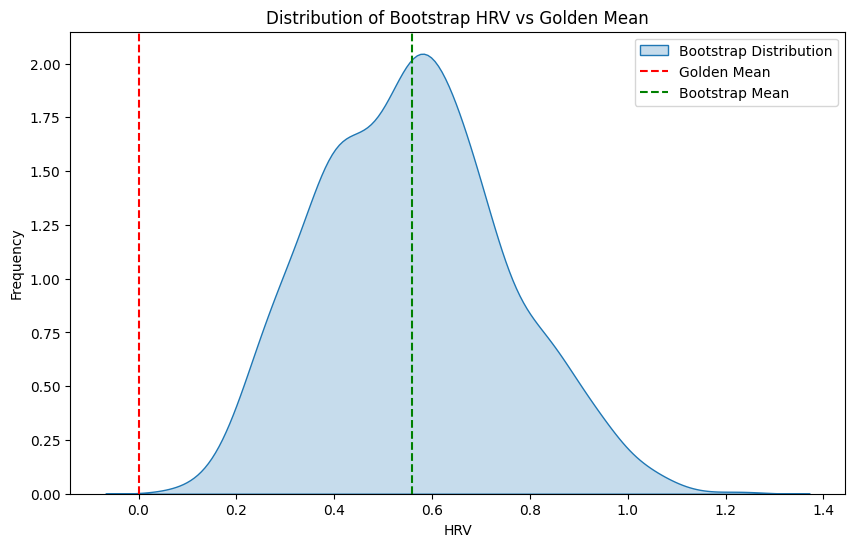

In [ ]:
#plot hrv distribution
golden_mean_hrv = hrv_values.mean()

#  mean from bootstrap distribution
bootstrap_mean_hrv = np.mean(hrv_res)

# Compare the values and calculate difference
print(f"Golden Mean Skewness of HRV: {golden_mean_hrv:.3f}")
#print bootstrap mean skewness of hrv
print(f"Bootstrap Mean Skewness of HRV: {bootstrap_mean_hrv:.3f}")
print(f"Difference: {abs(golden_mean_hrv - bootstrap_mean_hrv):.3f}")

# Visualize the comparison
plt.figure(figsize=(10, 6))
sns.kdeplot(data=hrv_res, fill=True, label='Bootstrap Distribution')
plt.axvline(golden_mean_hrv, color='r', linestyle='--', label='Golden Mean')
plt.axvline(bootstrap_mean_hrv, color='g', linestyle='--', label='Bootstrap Mean')
plt.title('Distribution of Bootstrap HRV vs Golden Mean')
plt.xlabel('HRV')
plt.ylabel('Frequency')
plt.legend()
plt.show()


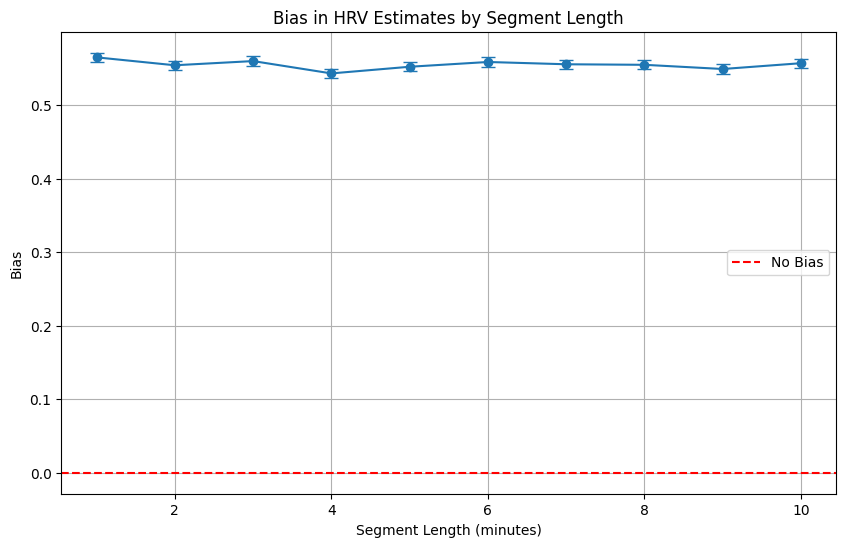

In [ ]:
def calculate_bias_hrv(hrv_values, bootstrap_results, seg_lengths):
    # Calculate true HRV (mean of the differences)
    true_hrv = np.mean(hrv_values)
    
    # Create a DataFrame from bootstrap results
    df_results = pd.DataFrame({
        'seg_len': [sl for sl in seg_lengths for _ in range(len(bootstrap_results[0]))],
        'hrv_skewness': np.concatenate(bootstrap_results)
    })
    
    # Calculate bias for each bootstrap iteration
    df_results['bias'] = df_results['hrv_skewness'] - true_hrv
    
    # Calculate mean bias and SE for each segment length
    bias_results = []
    for seg in seg_lengths:
        seg_bias = df_results[df_results['seg_len'] == seg]['bias']
        mean_bias = seg_bias.mean()
        bias_se = seg_bias.std() / np.sqrt(len(seg_bias))
        
        bias_results.append({
            'segment_length': seg,
            'mean_bias': mean_bias,
            'bias_se': bias_se
        })
    
    return pd.DataFrame(bias_results)


seg_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # minutes
bootstrap_results = []  
# Collect bootstrap results for each segment length
for seg_len in seg_lengths:
    res = bootstrap_hrv_skewness(hrv_values, seg_len, n_iterations=1000)
    bootstrap_results.append(res)

# Calculate and plot bias
bias_results = calculate_bias_hrv(hrv_values, bootstrap_results, seg_lengths)

plt.figure(figsize=(10, 6))
plt.errorbar(bias_results['segment_length'], 
            bias_results['mean_bias'],
            yerr=bias_results['bias_se'],
            fmt='o-',
            capsize=5)
plt.axhline(y=0, color='r', linestyle='--', label='No Bias')
plt.xlabel('Segment Length (minutes)')
plt.ylabel('Bias')
plt.title('Bias in HRV Estimates by Segment Length')
plt.legend()
plt.grid(True)
plt.show()

Simple Entropy calcuation

In [ ]:
# Simple Entropy with neurokit2
# Finding simple entropy of the data
def calculate_entropy(ibi):
    entropy = nk.entropy_sample(ibi)  # Using neurokit2's entropy function
    return (entropy['entropy'])

entropy_values = calculate_entropy(hrv_values)
#convert to int
entropy_values = int(entropy_values[0]) 
print(entropy_values) 


TypeError: tuple indices must be integers or slices, not str

In [ ]:
#bootstrap entropy 
def bootstrap_entropy(entropy_values, seg_length_min, n_iterations=1000):
    entropies = []
    for _ in tqdm(range(n_iterations), leave=False):
        # Sample HRV values with replacement
        bootstrap_sample = np.random.choice(entropy_values, size=len(entropy_values), replace=True)
        # Create time values (cumulative sum of intervals)
        time = np.cumsum(bootstrap_sample)
        # Create segments based on minutes
        segments = (time / 60 / seg_length_min).astype(int)
        # Calculate skewness for each segment
        temp_df = pd.DataFrame({'entropy': bootstrap_sample, 'segment': segments})
        segment_entropies = temp_df.groupby('segment')['entropy'].apply(skew)
        entropies.append(np.mean(segment_entropies))
    return entropies

In [ ]:
#bootstrap entropy for 1 seg length
entropy_values =calculate_entropy(hrv_values)
seg_length = 1
entropy_res = bootstrap_entropy(entropy_values, seg_length, 1000)
print("Bootstrap Entropy for 1 minutes:", entropy_res)



In [ ]:
entropy_values =calculate_entropy(hrv_values)
seg_length = 2
entropy_res = bootstrap_entropy(entropy_values, seg_length, 1000)
print("Bootstrap Entropy for 2 minutes:", entropy_res)

In [ ]:
entropy_values =calculate_entropy(hrv_values)
seg_length = 3
entropy_res = bootstrap_entropy(entropy_values, seg_length, 1000)
print("Bootstrap Entropy for 3 minutes:", entropy_res)

In [ ]:
entropy_values =calculate_entropy(hrv_values)
seg_length = 4
entropy_res = bootstrap_entropy(entropy_values, seg_length, 1000)
print("Bootstrap Entropy for 4 minutes:", entropy_res)

In [ ]:
entropy_values =calculate_entropy(hrv_values)
seg_length = 5
entropy_res = bootstrap_entropy(entropy_values, seg_length, 1000)
print("Bootstrap Entropy for 5 minutes:", entropy_res)

In [ ]:
entropy_values =calculate_entropy(hrv_values)
seg_length = 6
entropy_res = bootstrap_entropy(entropy_values, seg_length, 1000)
print("Bootstrap Entropy for 6 minutes:", entropy_res)

In [ ]:
entropy_values =calculate_entropy(hrv_values)
seg_length = 7
entropy_res = bootstrap_entropy(entropy_values, seg_length, 1000)
print("Bootstrap Entropy for 7 minutes:", entropy_res)

In [ ]:
entropy_values =calculate_entropy(hrv_values)
seg_length = 8
entropy_res = bootstrap_entropy(entropy_values, seg_length, 1000)
print("Bootstrap Entropy for 8 minutes:", entropy_res)

In [ ]:
entropy_values =calculate_entropy(hrv_values)
seg_length = 9
entropy_res = bootstrap_entropy(entropy_values, seg_length, 1000)
print("Bootstrap Entropy for 9 minutes:", entropy_res)

In [ ]:
entropy_values =calculate_entropy(hrv_values)
seg_length = 10
entropy_res = bootstrap_entropy(entropy_values, seg_length, 1000)
print("Bootstrap Entropy for 10 minutes:", entropy_res)

In [ ]:
#plot entropy distribution
golden_mean_entropy = entropy_values.mean()

#  mean from bootstrap distribution
bootstrap_mean_entropy = np.mean(entropy_res)

# Compare the values and calculate difference
print(f"Golden Mean Skewness of HRV: {golden_mean_entropy:.3f}")
#print bootstrap mean skewness of hrv
print(f"Bootstrap Mean Skewness of HRV: {bootstrap_mean_entropy:.3f}")
print(f"Difference: {abs(golden_mean_entropy - bootstrap_mean_entropy):.3f}")

# Visualize the comparison
plt.figure(figsize=(10, 6))
sns.kdeplot(data=entropy_res, fill=True, label='Bootstrap Distribution')
plt.axvline(golden_mean_entropy, color='r', linestyle='--', label='Golden Mean')
plt.axvline(bootstrap_mean_entropy, color='g', linestyle='--', label='Bootstrap Mean')
plt.title('Distribution of Bootstrap Entropy vs Golden Mean')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
def calculate_bias_entropy(entropy_values, bootstrap_results, seg_lengths):
    # Calculate true HRV (mean of the differences)
    true_entropy = np.mean(entropy_values)
    
    # Create a DataFrame from bootstrap results
    df_results = pd.DataFrame({
        'seg_len': [sl for sl in seg_lengths for _ in range(len(bootstrap_results[0]))],
        'entropy_skewness': np.concatenate(bootstrap_results)
    })
    
    # Calculate bias for each bootstrap iteration
    df_results['bias'] = df_results['entropy_skewness'] - true_entropy
    
    # Calculate mean bias and SE for each segment length
    bias_results = []
    for seg in seg_lengths:
        seg_bias = df_results[df_results['seg_len'] == seg]['bias']
        mean_bias = seg_bias.mean()
        bias_se = seg_bias.std() / np.sqrt(len(seg_bias))
        
        bias_results.append({
            'segment_length': seg,
            'mean_bias': mean_bias,
            'bias_se': bias_se
        })
    
    return pd.DataFrame(bias_results)


seg_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # minutes
bootstrap_results = []  
# Collect bootstrap results for each segment length
for seg_len in seg_lengths:
    res = bootstrap_entropy(entropy_values, seg_len, n_iterations=1000)
    bootstrap_results.append(res)

# Calculate and plot bias
bias_results = calculate_bias_entropy(entropy_values, bootstrap_results, seg_lengths)

plt.figure(figsize=(10, 6))
plt.errorbar(bias_results['segment_length'], 
            bias_results['mean_bias'],
            yerr=bias_results['bias_se'],
            fmt='o-',
            capsize=5)
plt.axhline(y=0, color='r', linestyle='--', label='No Bias')
plt.xlabel('Segment Length (minutes)')
plt.ylabel('Bias')
plt.title('Bias in Entropy Estimates by Segment Length')
plt.legend()
plt.grid(True)
plt.show()